In [1]:
import scanpy as sc
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import warnings
warnings.filterwarnings('ignore')

In [2]:
adata = sc.read_10x_h5("atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5", gex_only=False)
print(adata)

AnnData object with n_obs × n_vars = 9277 × 80234 
    var: 'gene_ids', 'feature_types', 'genome'


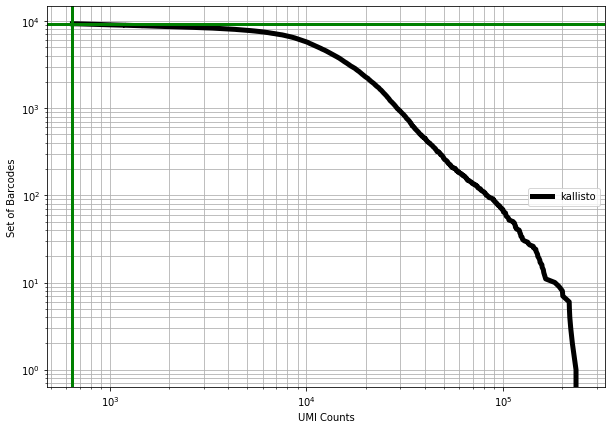

In [3]:
######################
# Make the knee plot #
######################
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))
expected_num_cells=9276

ax.loglog(knee, range(len(knee)), label="kallisto", linewidth=5, color="k")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="g")
ax.axhline(y=expected_num_cells, linewidth=3, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
ax.legend()

In [4]:
########################
# Analysis with ScanPy #
########################
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 9270 × 78700 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

... storing 'feature_types' as categorical
... storing 'genome' as categorical


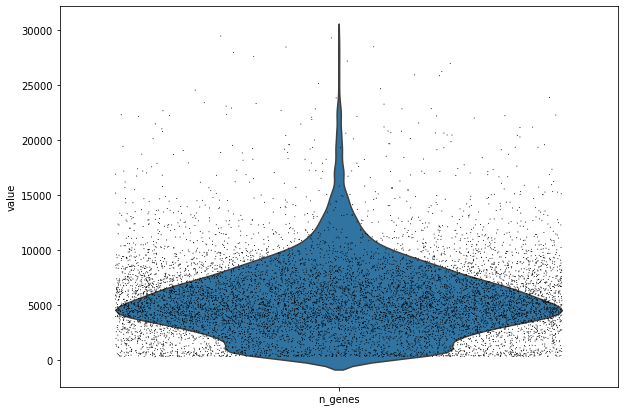

In [5]:
#########################
# Distribution of genes #
#########################
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_genes', jitter=0.4, ax=ax)

In [6]:
######################################
# Normalize the counts in the matrix #
######################################
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

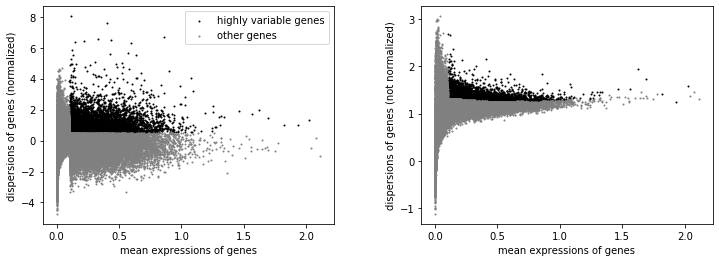

In [7]:
#########################
# Highly variable peaks #
#########################
sc.pp.highly_variable_genes(adata, min_disp=0.5, min_mean=0.1, inplace=True)
sc.pl.highly_variable_genes(adata)
adata  = adata[:, adata.var['highly_variable']]


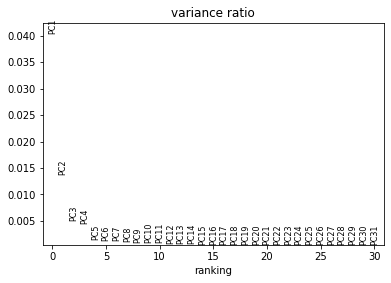

In [8]:
##########################################
# Cluster with Leiden and Plot PCA, UMAP #
##########################################
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata)

sc.pp.neighbors(adata, n_pcs=10)
sc.tl.umap(adata)

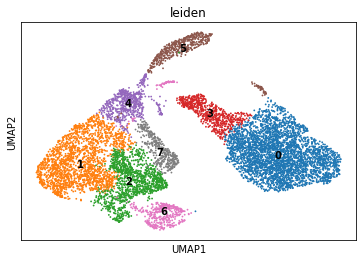

In [9]:
sc.tl.leiden(adata, resolution=0.2, random_state=0)
sc.pl.umap(adata, color='leiden', legend_loc = "on data")

In [10]:
##########################
# Finding 'marker' peaks #
##########################
sc.tl.rank_genes_groups(adata,'leiden', method='wilcoxon', n_genes=1000)

In [11]:
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
logFC = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
pVals = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
padj = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])

In [12]:
# select significant peaks and save dataframe for each cluster
for i in range(8):
    all_sig = pd.concat([names[str(i)],logFC[str(i)],pVals[str(i)],padj[str(i)]], keys=['names','logFC','pVals','padj'], axis =1)
    all_sig = all_sig[all_sig['pVals']<=0.05]
    all_sig.to_csv('top_cl_'+str(i)+'.csv',index=False)